# Đọc data

In [31]:
!pip install tiktoken
!pip install scikit-learn

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import pandas as pd

# Đọc tệp CSV huấn luyện
train_df = pd.read_csv('/content/drive/MyDrive/train_set_filtered.csv')
# Lọc dữ liệu
train_df = train_df[~train_df['label_numeric'].isin([1, 2, 8])]

# Tạo ánh xạ mới từ label sang label_numeric
new_label_mapping = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

# Gán lại label_numeric
train_df['label_numeric'] = train_df['label'].map(new_label_mapping)

print("Trainning Set:")
train_df.head()


Trainning Set:


,_id,label,title,label_numeric
0,66b5aabf8a38820e82e0b6ce,Xu hướng,"100+ STT Né thính, Cap né thính hài hước, NÉT ...",5
1,66b5a9838a38820e82e0b64d,Xu hướng,"Top 111+ stt cuộc sống an nhiên, bình dị tự tạ...",5
2,66b5cb358a38820e82e0c408,Xu hướng,"Top hạt giống hoa dễ trồng, nở quanh năm cho n...",5
3,66b5c7a78a38820e82e0c294,Nhà,Top 10 quạt cây hơi nước được ưa chuộng nhất h...,2
4,66b5cab28a38820e82e0c3d3,Xu hướng,Bộ nhớ trong là gì? Bộ nhớ trong trên điện tho...,5


In [34]:
unique_pairs = train_df[["label", "label_numeric"]].drop_duplicates().sort_values(by="label_numeric")
print(unique_pairs)
print(f"\nSố lượng nhãn: {len(unique_pairs)}")

        label  label_numeric
23  Công Nghệ              0
8     Làm Đẹp              1
3         Nhà              2
7      Trẻ em              3
5   Tài chính              4
0    Xu hướng              5

Số lượng nhãn: 6


In [35]:
# Tăng thêm số mẫu cho các nhãn cụ thể (0, 2, 3, 4)
labels_to_augment = [0, 2, 3, 4]
samples_to_add = {
    0: 300,
    2: 300,
    3: 200,
    4: 300,
}

augmented_rows = []

for label in labels_to_augment:
    subset = train_df[train_df['label_numeric'] == label]
    # Lấy ngẫu nhiên một số dòng có lặp lại từ nhãn này
    duplicated = subset.sample(n=samples_to_add[label], replace=True, random_state=42)
    augmented_rows.append(duplicated)

# Ghép thêm các dòng được nhân bản vào train_df gốc
train_df = pd.concat([train_df] + augmented_rows, ignore_index=True)

# Shuffle dữ liệu sau khi thêm
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# In thống kê lại
print("✅ Số lượng mẫu mỗi nhãn sau oversample nhẹ:")
print(train_df['label_numeric'].value_counts().sort_index())

# Nếu bạn muốn giữ cả label (tên nhãn)
train_df = pd.concat([train_df] + augmented_rows, ignore_index=True)[['title', 'label', 'label_numeric']]

✅ Số lượng mẫu mỗi nhãn sau oversample nhẹ:
label_numeric
0     541
1    1435
2     586
3     633
4     492
5    1801
Name: count, dtype: int64


In [36]:
# Đọc tệp CSV xác thực
validation_df = pd.read_csv('/content/drive/MyDrive/validation_set_filtered.csv')

# Lọc dữ liệu
validation_df = validation_df[~validation_df['label_numeric'].isin([1, 2, 8])]

# Tạo ánh xạ mới từ label sang label_numeric
new_label_mapping = {label: idx for idx, label in enumerate(sorted(validation_df['label'].unique()))}

# Gán lại label_numeric
validation_df['label_numeric'] = validation_df['label'].map(new_label_mapping)

print('Validation Set:')
validation_df.head()

Validation Set:


,_id,label,title,label_numeric
0,66b5a0f18a38820e82e0b2cb,Công Nghệ,Tổng hợp Code Hiền Nhân Thuật mới nhất 08/2024,0
1,66b5cdc28a38820e82e0c518,Làm Đẹp,"Cách chăm sóc da nhờn ở nam giới, top sản phẩm...",1
2,66b5a0ad8a38820e82e0b2ae,Làm Đẹp,Review Top 4 kem chống nắng Goodal bán chạy nh...,1
3,66b5db8b8a38820e82e0caad,Công Nghệ,Review điện thoại Xiaomi Redmi K40 thực tế sau...,0
4,66b5d41a8a38820e82e0c7b3,Xu hướng,Bật mí với bạn 10 cách chăm sóc cây cảnh trong...,5


In [37]:
print(len(train_df))
print(len(validation_df))

6588
950


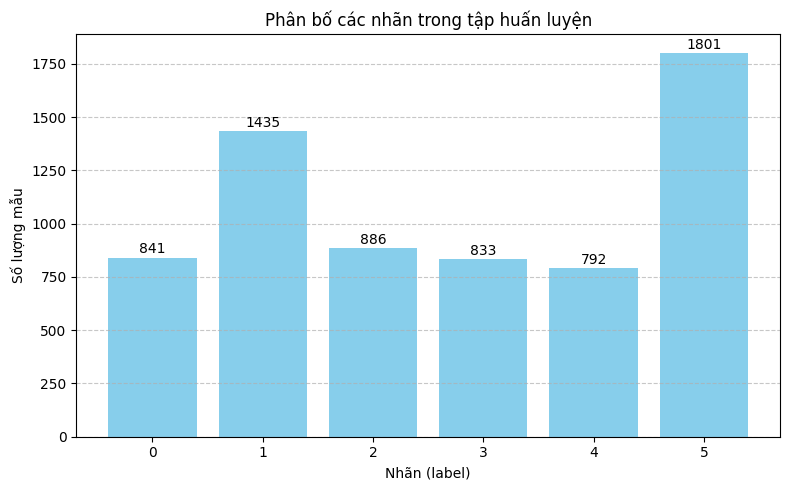

In [38]:
import matplotlib.pyplot as plt
# Đếm số lượng mỗi nhãn
label_counts = train_df['label_numeric'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
bars = plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.title("Phân bố các nhãn trong tập huấn luyện")
plt.xlabel("Nhãn (label)")
plt.ylabel("Số lượng mẫu")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Thêm số lượng mẫu lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

# Xử lý dữ liệu

In [39]:
import tiktoken

# Chọn tokenizer GPT sử dụng tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

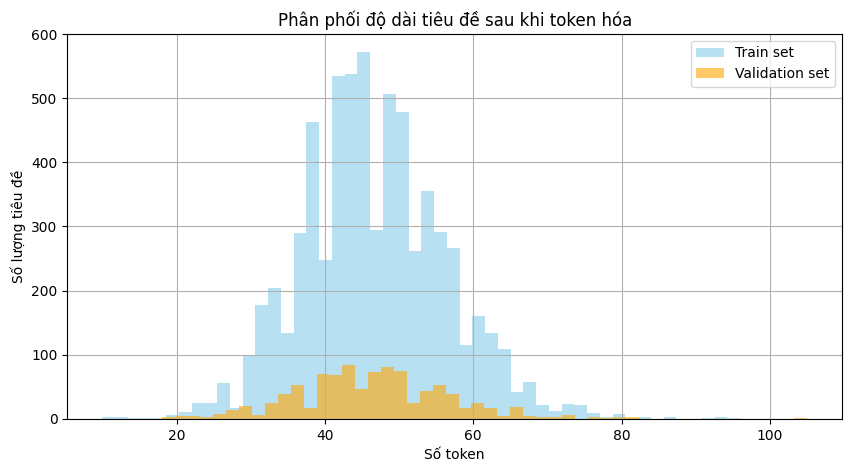

In [40]:
# Đo độ dài tiêu đề (sau khi token hóa bằng tiktoken)
train_lengths = [len(tokenizer.encode(title.lower())) for title in train_df['title']]
val_lengths = [len(tokenizer.encode(title.lower())) for title in validation_df['title']]

# Vẽ histogram
plt.figure(figsize=(10,5))
plt.hist(train_lengths, bins=50, alpha=0.6, label='Train set', color='skyblue')
plt.hist(val_lengths, bins=50, alpha=0.6, label='Validation set', color='orange')
plt.title('Phân phối độ dài tiêu đề sau khi token hóa')
plt.xlabel('Số token')
plt.ylabel('Số lượng tiêu đề')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split

class TextDataset(Dataset):
  def __init__(self, dataframe, tokenizer):
      # Chuyển tiêu đề thành chữ thường
      self.titles = dataframe['title'].str.lower().tolist() # lower() không thể áp trực tiếp vào Pandas
      self.labels = dataframe['label_numeric'].values # chuyển dữ liệu từ Pandas sang np.array
      self.tokenizer = tokenizer

  def __len__(self):
      return len(self.titles)

  def __getitem__(self, idx):
      title = self.titles[idx]
      label = self.labels[idx]

      # Token hóa title
      encoding = self.tokenizer.encode(title)

      # Chuyển đổi mã hóa thành tensor của Pytorch
      input_ids = torch.tensor(encoding)

      return input_ids, label

# Tạo các dataset cho tập train và validation
train_dataset = TextDataset(train_df, tokenizer)
val_dataset = TextDataset(validation_df, tokenizer)


In [42]:
# Tạo DataLoader để chia thành các batch
batch_size = 32

def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Tìm độ dài lớn nhất trong batch này
    max_length = max(len(s) for s in input_ids)

    # Thêm padding vào các chuỗi
    padded_input_ids = []
    for ids in input_ids:
      padding = torch.zeros(max_length - len(ids), dtype=torch.long)
      padded_input_ids.append(torch.cat([ids, padding]))

    # Chuyển list -> tensor [batch_size, max_length]
    input_ids = torch.stack(padded_input_ids)

    # Chuyển đổi labels thành LongTensor
    labels = torch.tensor(labels, dtype=torch.long)

    return input_ids, labels

# Đưa Dataset vào để tạo Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Lập trình mạng GRU

In [43]:
# Khởi tạo mô hình
vocab_size = tokenizer.n_vocab # Kích thước của từ điển tokenizer
embed_size = 128 # Kích thước của embedding token
hidden_size = 256 # Kích thước của hidden state trong GRU
output_size = len(train_df['label_numeric'].unique()) # Số lượng nhãn
num_layers = 2 # Số lượng lớp GRU


In [44]:
# Định nghĩa cell GRU tùy chỉnh
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size):
      super(GRUCell, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size

      # Trọng số của update gate
      self.W_z = nn.Linear(input_size, hidden_size, bias=True)
      self.U_z = nn.Linear(hidden_size, hidden_size, bias=False)

      # Trọng số của reset gate
      self.W_r = nn.Linear(input_size, hidden_size, bias=True)
      self.U_r = nn.Linear(hidden_size, hidden_size, bias=False)

      # Trọng số của candidate hidden state
      self.W_h = nn.Linear(input_size, hidden_size, bias=True) # W trọng số cho input x_t
      self.U_h = nn.Linear(hidden_size, hidden_size, bias=False) # U trọng số cho hidden state h_{t-1}

  def forward(self, x, h_prev):
      z_t = torch.sigmoid(self.W_z(x) + self.U_z(h_prev)) # Update gate
      r_t = torch.sigmoid(self.W_r(x) + self.U_r(h_prev)) # Reset gate
      h_hat_t = torch.tanh(self.W_h(x) + self.U_h(r_t*h_prev)) # Candidate hidden state
      h_t = (1-z_t) * h_prev + z_t*h_hat_t
      return h_t



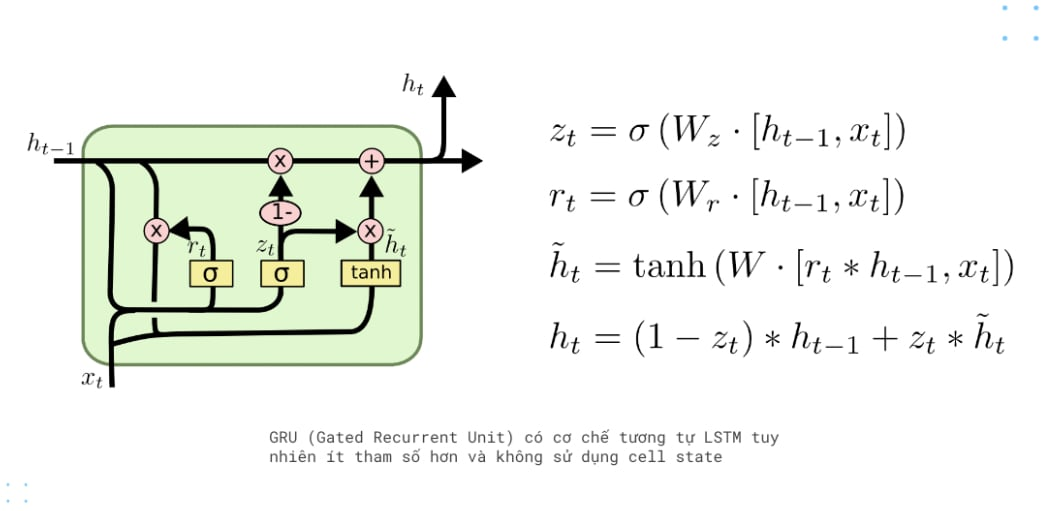

# Ghép GRU Cell bên trên vào mạng

In [45]:
import torch.nn as nn

# Định nghĩa mô hình GRU tùy chỉnh với chỉ một GRU cell
class GRUModel(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, output_size, dropout=0.3): # 30% các nơ-ron sẽ 'tạm thời tắt' trong mỗi bước trainning -> chống overfitting
    super(GRUModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size) # Từ điển sẽ có n_vocab token, mỗi token khi qua embedding thành vector 128 chiều
    self.gru_cell = nn.GRUCell(embed_size, hidden_size) # Sử dụng chỉ một GRU cell
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    embedded = self.embedding(x) # x.shape = (batch_size, sequence_length)
                                  # batch_size: số lượng câu được xử lý cùng lúc (ví dụ 32 nếu bạn dùng batch_size=32).
                                  # sequence_length: độ dài tối đa của mỗi câu (ví dụ 50 tokens mỗi câu).
    h = torch.zeros(x.size(0), self.gru_cell.hidden_size).to(x.device) # Trạng thái ẩn ban đầu (batch, hidden_size)

    for t in range(x.size(1)): # Duyệt qua từng bước thời gian
      x_t = embedded[:, t, :] # x sau khi qua embedding thì x.shape = (batch_size, sequence_length, embed_size)
      h = self.gru_cell(x_t, h) # Cập nhật trạng thái ẩn với cùng một GRU cell

    out = self.fc(self.dropout(h)) # Sử dụng trạng thái ẩn cuối cùng để phân loại
    return out



In [46]:
model = GRUModel(vocab_size, embed_size, hidden_size, output_size, dropout=0.3)

In [47]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

train_labels = train_dataset.labels

# Giả sử train_labels là list hoặc numpy array các nhãn lớp
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Chuyển thành Tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to('cpu')


In [48]:
# Vòng lặp huấn luyện
num_epochs = 10

# Hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4)

In [49]:
from sklearn.metrics import classification_report

best_val_loss = float('inf')  # Ban đầu coi như loss tốt nhất là vô cùng lớn
patience = 3                  # Số lần cho phép val_loss không giảm
trigger_times = 0             # Đếm số lần val_loss không cải thiện
best_model_state = None       # Lưu mô hình tốt nhất



# Trainning the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_ids, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_loss_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, labels in val_dataloader:
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * labels.size(0)  # Tổng loss theo sample
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct / total
    val_loss_avg = val_loss_total / total

    # Early stopping logic
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        trigger_times = 0
        best_model_state = model.state_dict()  # Lưu lại mô hình tốt nhất
        print("✅ Validation loss improved, saving model.")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement in validation loss. EarlyStopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            model.load_state_dict(best_model_state)  # Load lại model tốt nhất
            break  # Thoát khỏi vòng huấn luyện


    print(f"Validation Loss after Epoch {epoch+1}: {val_loss_avg:.4f}")
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.2f}%")



    # Classification Report (hiển thị mỗi epoch hoặc cuối cùng tùy bạn)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))


Epoch 1/10, Training Loss: 1.5335
✅ Validation loss improved, saving model.
Validation Loss after Epoch 1: 1.2615
Validation Accuracy after Epoch 1: 47.79%
Classification Report:
              precision    recall  f1-score   support

           0     0.3415    0.5957    0.4341        47
           1     0.6996    0.5897    0.6400       312
           2     0.2102    0.5238    0.3000        63
           3     0.5542    0.6389    0.5935        72
           4     0.1711    0.9143    0.2883        35
           5     0.7360    0.3112    0.4374       421

    accuracy                         0.4779       950
   macro avg     0.4521    0.5956    0.4489       950
weighted avg     0.6351    0.4779    0.5010       950

Epoch 2/10, Training Loss: 0.6651
✅ Validation loss improved, saving model.
Validation Loss after Epoch 2: 0.7103
Validation Accuracy after Epoch 2: 75.26%
Classification Report:
              precision    recall  f1-score   support

           0     0.4615    0.6383    0.5357 

🔍 Final Classification Report (Best Model):
              precision    recall  f1-score   support

           0     0.6429    0.5745    0.6067        47
           1     0.9386    0.8333    0.8829       312
           2     0.6047    0.8254    0.6980        63
           3     0.7595    0.8333    0.7947        72
           4     0.8571    0.6857    0.7619        35
           5     0.8470    0.8812    0.8638       421

    accuracy                         0.8358       950
   macro avg     0.7750    0.7722    0.7680       950
weighted avg     0.8447    0.8358    0.8374       950



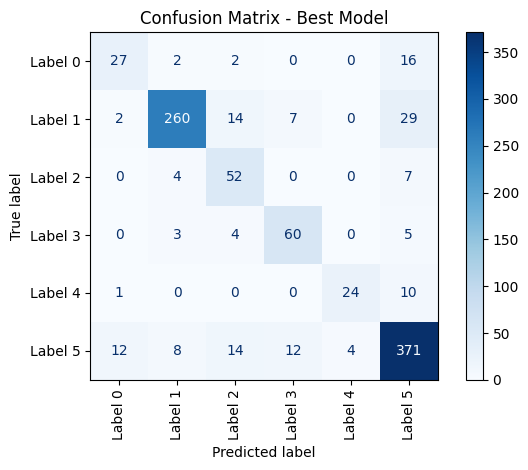

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ======= After training finishes (early stopping or normal end) =======

# # Load best model
# model.load_state_dict(best_model_state)
# model.eval()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, labels in val_dataloader:
        outputs = model(input_ids)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report cuối cùng
from sklearn.metrics import classification_report
print("🔍 Final Classification Report (Best Model):")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
num_classes = 6
class_names = [f"Label {i}" for i in range(num_classes)]  # Hoặc tên lớp cụ thể nếu có
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Best Model")
plt.tight_layout()
plt.show()


In [51]:
# Thay đổi metric đánh giá model
# Undersampling
# Oversampling
#   - Random
#   - Cluster
#   - SMOTE
# Class weighted
# Ensemble & Boosting

In [52]:
# torch.save(model.state_dict(), "model_GRU_last.pth")

In [55]:
model = GRUModel(vocab_size, embed_size, hidden_size, output_size, dropout=0.3)
model.load_state_dict(torch.load("/content/drive/MyDrive/model_GRU_last.pth"))
model.eval()

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [56]:
total = 0
correct = 0

for input_ids, labels in val_dataloader:
    outputs = model(input_ids)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0) # Cộng dồn qua các batch
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 9.58%


In [57]:
unique_pairs = train_df[["label", "label_numeric"]].drop_duplicates().sort_values(by="label_numeric")
print(unique_pairs)
print(f"\nSố lượng nhãn: {len(unique_pairs)}")

       label  label_numeric
0  Công Nghệ              0
2    Làm Đẹp              1
7        Nhà              2
1     Trẻ em              3
8  Tài chính              4
5   Xu hướng              5

Số lượng nhãn: 6


In [62]:
# Mapping từ số sang tên nhãn
label_mapping = {
    0: "Công Nghệ",
    1: "Làm Đẹp",
    2: "Nhà",
    3: "Trẻ em",
    4: "Tài chính",
    5: "Xu hướng"
}

def predict_sentence(model, tokenizer, sentence):
    model.eval()
    sentence = sentence.lower()
    input_ids = tokenizer.encode(sentence)
    input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        output = model(input_ids)

    _, predicted_label = torch.max(output, dim=1)

    # Trả về tên nhãn thay vì chỉ số
    return label_mapping[predicted_label.item()]

# Câu ví dụ
sentence = ""
predicted_label = predict_sentence(model, tokenizer, sentence)
print(f"Dự đoán của mô hình cho câu \"{sentence}\" là: {predicted_label}")


Dự đoán của mô hình cho câu "Mỹ phẩm Kera làm sáng da" là: Tài chính


In [ ]:
# !gdown 1isX7s6hChuJ4GHkVwP80C9DZtbfv1FXl

In [ ]:
# import torch
# import pandas as pd

# def predict_sentence(model, tokenizer, sentence):
#     """
#     Dự đoán nhãn cho một câu sử dụng mô hình GRU đã huấn luyện.

#     Parameters:
#     - model: Mô hình GRU đã huấn luyện.
#     - tokenizer: GPT tokenizer đã được khởi tạo.
#     - sentence: Câu cần dự đoán (chuỗi văn bản).

#     Returns:
#     - predicted_label: Nhãn dự đoán cho câu (số nguyên).
#     """
#     model.eval()
#     sentence = sentence.lower()
#     input_ids = tokenizer.encode(sentence)
#     input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0)

#     with torch.no_grad():
#         output = model(input_ids)
#     _, predicted_label = torch.max(output, dim=1)

#     return predicted_label.item()

# # Đọc tập test từ file CSV
# test_df = pd.read_csv('/content/test_set_public.csv')

# # Dự đoán nhãn cho từng tiêu đề trong tập test
# test_df['label_numeric'] = test_df['title'].apply(lambda x: predict_sentence(model, tokenizer, x))

# test_df.rename(columns={'_id': 'id'}, inplace=True)

# test_df = test_df.drop('title', axis=1)

# # Lưu kết quả vào file CSV
# test_df.to_csv('your_submissions1.csv', index=False)
